In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


C:\Users\carlo\AppData\Local\Temp\ipykernel_8996\2656127810.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

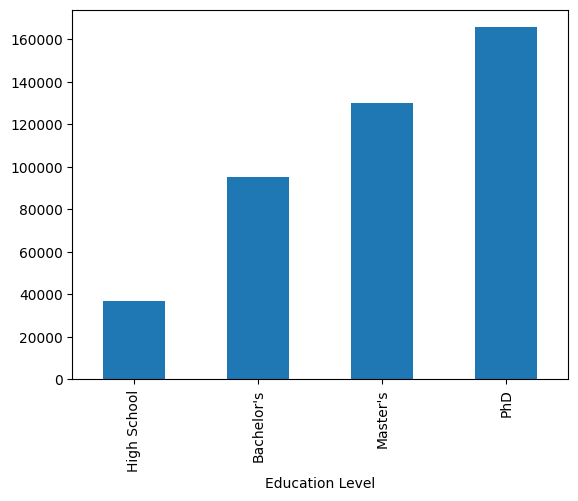

In [3]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

job = 'Software Engineer'
#df_job = df[df['Job Title'] == job]
df_job = df.copy()
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age'])

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping)

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_job['Gender'] = df_job['Gender'].map(gender_mapping)

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

scaler = StandardScaler()
train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

In [5]:
train

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
5107,-0.871098,1.0,2,Content Marketing Manager,-0.678455,-0.673554
6590,1.364455,0.0,1,Content Marketing Manager,1.148915,0.655858
4799,0.706940,1.0,3,Senior Research Scientist,0.816666,0.560900
2166,0.706940,1.0,2,Software Engineer Manager,0.650542,0.845774
1961,-0.871098,0.0,1,Back end Developer,-0.844579,-0.673554
...,...,...,...,...,...,...
1149,-0.476589,1.0,1,Software Engineer,-0.013957,1.225606
4579,0.049424,1.0,2,Director of HR,0.152168,-0.388680
2740,1.101449,0.0,2,Product Manager,0.982791,1.225606
3125,-0.739595,1.0,2,Full Stack Engineer,-0.678455,-0.622334


In [6]:
# Prepare data for PyTorch
# Prepare data for PyTorch
X_train = (train[['Years of Experience', 'Education Level', 'Gender', 'Age']])
y_train = (train['Salary'])
X_val = (val[['Years of Experience', 'Education Level', 'Gender', 'Age']])
y_val = (val['Salary'])
X_test = (test[['Years of Experience', 'Education Level', 'Gender', 'Age']])
y_test = (test['Salary'])

In [7]:
X_train

,Years of Experience,Education Level,Gender,Age
5107,-0.678455,2,1.0,-0.871098
6590,1.148915,1,0.0,1.364455
4799,0.816666,3,1.0,0.706940
2166,0.650542,2,1.0,0.706940
1961,-0.844579,1,0.0,-0.871098
...,...,...,...,...
1149,-0.013957,1,1.0,-0.476589
4579,0.152168,2,1.0,0.049424
2740,0.982791,2,0.0,1.101449
3125,-0.678455,2,1.0,-0.739595


Model Performance:
R-squared (R²) Score: 0.9052
Mean Absolute Error (MAE): $0.18
Root Mean Square Error (RMSE): $0.31


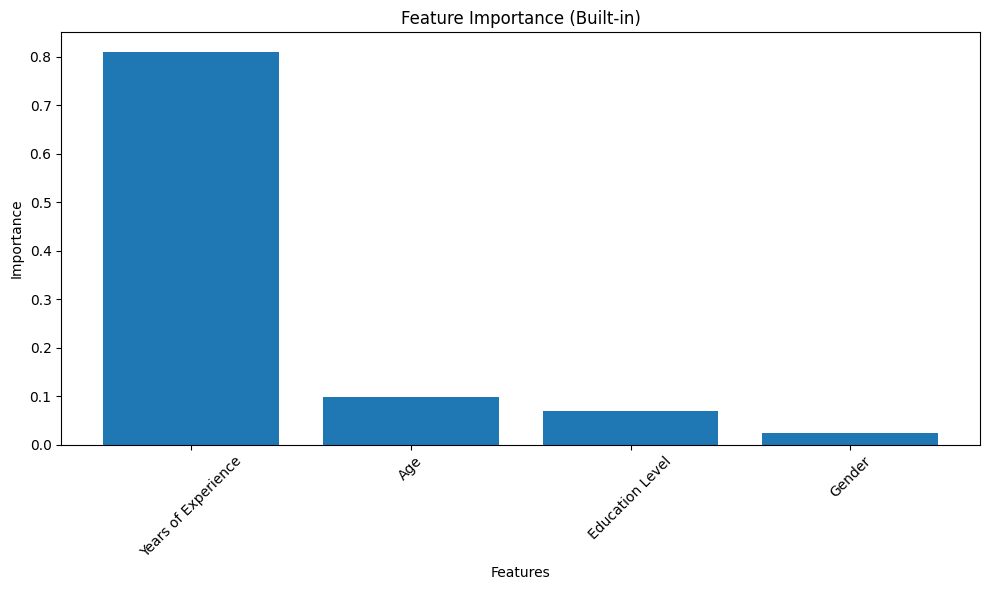

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

# Calculate accuracy metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")

# 1. Built-in Feature Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (Built-in)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

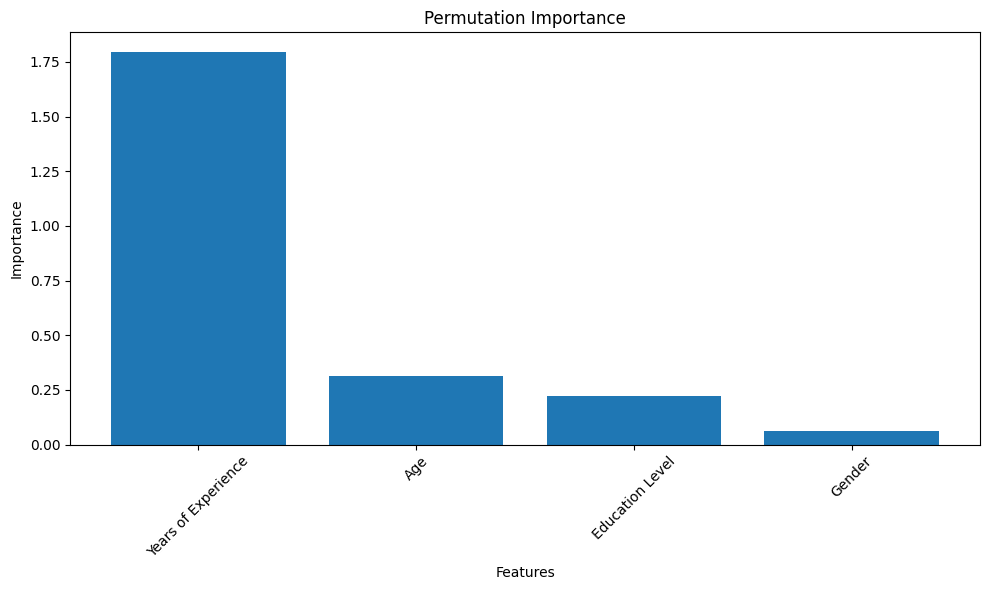

In [9]:
from sklearn.inspection import permutation_importance
# 2. Permutation Importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
})
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(perm_importance_df['feature'], perm_importance_df['importance'])
plt.title('Permutation Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def own_permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model(X).detach().numpy())
    importances = []
    
    for col in range(X.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, col] = torch.randperm(X.shape[0])
            permuted_mse = mean_squared_error(y, model(X_permuted).detach().numpy())
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return np.array(importances)